In [1]:
import netrc
import datetime
import requests
import numpy as np
import pandas as pd
from requests.auth import HTTPBasicAuth
from pydap.client import open_url
from pydap.cas.urs import setup_session

%matplotlib inline

In [2]:
url = 'http://jlrdata.umd.edu/opendap/thredds'
acct = netrc.netrc('/home/ubuntu/hydra/noaajpss.netrc')
usr,_,pswrd = acct.hosts[url]

In [3]:
response = requests.get(url, auth=HTTPBasicAuth(usr, pswrd))
print(response)
if response.status_code == 200:
    print('Connection is good')
else:
    print('Connection not made with THREDDS server')

<Response [200]>
Connection is good


In [4]:
s = requests.Session()
s.auth = (usr, pswrd)

In [5]:
dates = []
for i in range(2013,2017):
    jDays = np.random.choice(365,120,replace=False)
    for j in jDays:
        foy = datetime.datetime(i,1,1)
        date = foy + datetime.timedelta(days=int(j))
        dates.append(date)
        
print(len(dates))

480


In [6]:
def calibrate(data,gain):
    out = np.zeros_like(data).astype(float)
    for i in range(data.shape[2]):
        for j in range(data.shape[0]):
            out[j,:,i] = (data[j,:,i].astype(float) * gain[j,i]) *0.0001
            
    return out

In [ ]:
now = datetime.datetime.now()

useSDR = True
if useSDR:
    baseurl = 'http://jlrdata.umd.edu/opendap/thredds/SNPP/snppatmssdr{0}/{1}/{2}'
else:
    baseurl = 'http://jlrdata.umd.edu/opendap/thredds/SNPP/snppatm{0}/{1}/{2}'
    
dataurl = 'http://jlrdata.umd.edu/opendap/hyrax/SATMS/{0}/{1}/{2}'

tbiBar_water = []
tbiBar_land = []
samps_water = []
samps_land = []
fails = []


for t in range(len(dates)):
    date = dates[t]
    dateurl = baseurl.format(date.year,date.strftime("%Y-%m-%d"),'catlog.html')
    print(dateurl)
    r = requests.get(dateurl,auth=HTTPBasicAuth(usr, pswrd))
    if response.status_code == 200:
        files = data = [i.split('">')[1][:-4] for i in r.text.split('\n')[75:] if 'dataset' in i]
        which = np.random.choice(len(files),500,replace=False)
        for f in range(which.size):
            try:
                fileurl = dataurl.format(date.year,date.strftime("%Y-%m-%d"),files[which[f]])
                ds = open_url(fileurl,session=s)
                raw = ds['All_Data_ATMS_SDR_All_BrightnessTemperature'][:,:,:]
                cal = ds['All_Data_ATMS_SDR_All_GainCalibration'][:,:,:]

                data = calibrate(raw,cal)
                data = np.ma.masked_where(data<0,data)
                
                wl_mask = data[:,:,0] > 170
                dims = (wl_mask.shape[0],wl_mask.shape[1],raw.shape[2])
                wl_mask = np.broadcast_to(wl_mask,dims)
                
                water = np.ma.masked_where(wl_mask==0,data)
                land = np.ma.masked_where(wl_mask==1,data)
                
                nadirW = np.mean(water[:,47:49,:],axis=(1))
                nadirL = np.mean(land[:,47:49,:],axis=(1))
                
                tbiBar_water.append(nadirW)
                tbiBar_land.append(nadirL)
                
                for j in range(data.shape[0]):
                    samps_water.append(water[j,:,:])
                    samps_land.append(land[j,:,:])
            except:
                print('Failed at {}'.format(files[which[f]]))
                fails.append([date,files[which[f]]])
            
    else:
        print('Broke at {0}'.format(date))
        break
        
        
print('Processing time: {}'.format(datetime.datetime.now()-now))

http://jlrdata.umd.edu/opendap/thredds/SNPP/snppatmssdr2013/2013-07-06/catlog.html
http://jlrdata.umd.edu/opendap/thredds/SNPP/snppatmssdr2013/2013-04-22/catlog.html
http://jlrdata.umd.edu/opendap/thredds/SNPP/snppatmssdr2013/2013-12-06/catlog.html


In [9]:
print(len(samps_land))
tl = np.array(samps_land)
tw = np.array(samps_water)

print(t.shape)
tbij_l = np.mean(tl,axis=0)
tbij_w = np.mean(tw,axis=0)

74484
(74484, 96, 22)


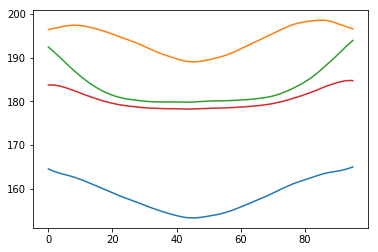

In [10]:
import matplotlib.pyplot as plt
plt.plot(tbij[:,:4])

In [11]:
tbi = np.mean(t[:,47:49,:],axis=(1))
tbi.shape

(74484, 22)

In [12]:
predictors = {'C1':[0,1],'C2':[0,1],'C3':[2,3,4],'C4':[2,3,4],'C5':[3,4,5],'C6':[4,5,6],'C7':[5,6,7],
              'C8':[6,7],'C9':[8,9,10],'C10':[9,10],'C11':[9,10,11],'C12':[10,11,12],'C13':[11,12],'C14':[11,12,13],
              'C15':[13,15],'C16':[0,15],'C17':[16,17],'C18':[17,18],'C19':[17,18,19],'C20':[18,19,20],'C21':[19,20,21],'C22':[20,21]
             }
print(list(predictors.keys()))


['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22']
22


In [13]:

xIdx = np.array([i for i in range(t.shape[1]) if i not in [47,48]])

Xs = {}
Ys = {}
keys = list(predictors.keys())

for c in range(len(keys)):
    chnl = keys[c]
    preds = predictors[chnl]
    
    X = {}
    Y = []

    for i in range(tbij.shape[0]):
        for p in range(len(preds)):
            if i == 0:
                X[p] = []
            X[p].append(t[i,xIdx,predictors[chnl][p]])
        for j in xIdx:
            Y.append(tbi[i,c])


    Xs[chnl] = [np.array(l).ravel() for l in X.values()]
    Ys[chnl] = np.array(Y)

In [14]:
Xs['C1'][0].shape
Ys['C1'].shape

(9024,)

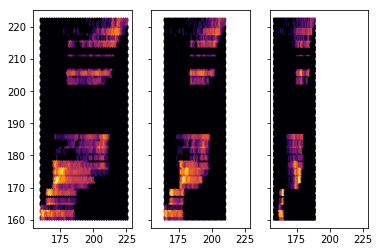

In [15]:
channel = 'C3'

ps = len(Xs[channel])

fig,ax = plt.subplots(ncols=ps,sharex=True,sharey=True)

for i in range(ps):
    ax[i].hexbin(Xs[channel][i],Ys[channel],gridsize=50, bins='log', cmap='inferno')
plt.show()

In [16]:
from scipy import optimize

def var3_lin(x,a,b,c):
    return a*x[0] + b*x[1] + c*x[2]

def var2_lin(x,a,b):
    return a*x[0] + b*x[1]

coeffs = {}

for c in range(len(keys)):
    chnl = keys[c]
    
    nvars = len(Xs[chnl])
    if nvars == 2:
        func = var2_lin
    else:
        func = var3_lin

    popt, pcov = optimize.curve_fit(func, Xs[chnl],Ys[chnl])
    
    coeffs[chnl] = {'popt':popt,'pcov':pcov}
    
print(coeffs)


{'C1': {'popt': array([ 1.50028978, -0.44859886]), 'pcov': array([[ 0.00031902, -0.00026131],
       [-0.00026131,  0.00021476]])}, 'C2': {'popt': array([ 1.26307214, -0.06988343]), 'pcov': array([[ 0.00057111, -0.0004678 ],
       [-0.0004678 ,  0.00038446]])}, 'C3': {'popt': array([ 2.6218989 , -4.07446193,  2.55857802]), 'pcov': array([[ 0.00309908, -0.00662022,  0.00369536],
       [-0.00662022,  0.01445571, -0.00822652],
       [ 0.00369536, -0.00822652,  0.00475927]])}, 'C4': {'popt': array([ 1.18274643, -1.76799138,  1.65297254]), 'pcov': array([[ 0.00117481, -0.00250961,  0.00140085],
       [-0.00250961,  0.00547991, -0.00311853],
       [ 0.00140085, -0.00311853,  0.00180416]])}, 'C5': {'popt': array([ 0.02161068,  1.17102767, -0.19158502]), 'pcov': array([[ 0.00016215, -0.00046407,  0.00029331],
       [-0.00046407,  0.00144017, -0.00095186],
       [ 0.00029331, -0.00095186,  0.00064343]])}, 'C6': {'popt': array([0.76837001, 0.1175027 , 0.17069344]), 'pcov': array([[ 9.8371

In [17]:
data = {}
for c in range(len(keys)):
    chnl = keys[c]
    data[chnl] = {}
    data[chnl]['Tbij'] = tbij[:,c]
    data[chnl]['Tbi'] = Ys[chnl].mean()
    data[chnl]['popt'] = coeffs[chnl]['popt']
    data[chnl]['pcov'] = coeffs[chnl]['pcov']
    data[chnl]['predictors'] = np.array(predictors[chnl])
    

df = pd.DataFrame.from_dict(data)
df.C1

Tbi                                                     149.414
Tbij          [164.51313840717864, 164.18496422174502, 163.8...
pcov          [[0.00031901978856339636, -0.00026131040539689...
popt                  [1.5002897759473175, -0.4485988596355765]
predictors                                               [0, 1]
Name: C1, dtype: object

In [18]:
df.to_hdf('/home/ubuntu/notebooks/src/hydra/atms_mlc_coeffs.hdf','table')

/home/ubuntu/anaconda3/envs/hydra/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2', 'C20', 'C21', 'C22', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


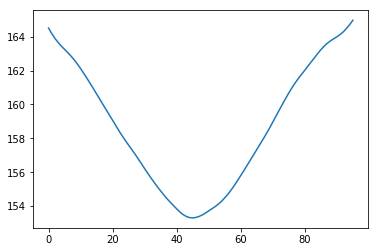

In [19]:
plt.plot(df.C1.Tbij)

In [20]:
test = df.to_dict()
test

{'C1': {'Tbi': 149.41366953913968,
  'Tbij': array([164.51313841, 164.18496422, 163.89957798, 163.66072877,
         163.4440769 , 163.2533014 , 163.06429847, 162.85849944,
         162.6347342 , 162.38858015, 162.12066423, 161.83601966,
         161.54227823, 161.23991256, 160.93279338, 160.62096736,
         160.30777635, 159.99376869, 159.68576173, 159.3739514 ,
         159.06572746, 158.75153898, 158.44046503, 158.14307129,
         157.86574038, 157.5971833 , 157.33087756, 157.06548491,
         156.78533214, 156.49919523, 156.20979524, 155.92826343,
         155.65491844, 155.39120576, 155.13616257, 154.89180025,
         154.65700008, 154.43110596, 154.22590255, 154.02810606,
         153.83371714, 153.65182103, 153.49897919, 153.38656179,
         153.32150239, 153.30139004, 153.3286366 , 153.39056336,
         153.47940533, 153.5929511 , 153.71621599, 153.84145843,
         153.97022701, 154.11448505, 154.28240945, 154.48523489,
         154.70398862, 154.9515703 , 155.224151